# CoverWallet Test: The Account Value Case Dilemma

---



---
Given:
- a list of clients (accounts) and their basic company info.
- a set of quotes replied to those potential clients, about certain products and their price (premium).
- an observed fact named "convert" meaning that the account finally acquired the quoted product.
- the account value definition as the sum of premiums related to quotes which were finally acquired.

The goal is to resolve:
1. What is the expected account value for any potential client?

In the process, the provided data will be analyzed in order to find as many  meaningful insights as possible.

## 0. Approach
To extract conclusions we will follow these steps:
1. Libraries and packages: import necessary Python modules
2. Reading data:
* Csv files will be read and checked in terms of headers.
* Column formats and null values will be analyzed.
3. Understanding dataset structure:
* How the datasets are configured, how they can be merged, what they contain and their internal behaviour, what a row means.
* Every column will be looked at in a univariate analysis.
4. Understanding the target variable and modeling:
* Which variable is the actual target? Conversion versus Account value.
* How the target variable behaves compared to the other columns in a multivariate analysis.
* Using our data for classification model training.
5. Evaluating results:
* Comparing the different models obtained in the previous step in terms of predictions using RMSE and other metrics.
6. Conclusions

## 1. Libraries and packages

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 8))
import seaborn as sns
sns.set(color_codes=True)
import random
import pickle

!pip install pytictoc
from pytictoc import TicToc

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import  roc_curve, auc, recall_score, precision_score,f1_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

!pip install catboost
from catboost import CatBoostClassifier

     |████████████████████████████████| 76.1 MB 1.1 MB/s 


## 2. Reading data

In [2]:
#Read received csv
f_accounts_train = '/content/drive/MyDrive/ColabNotebooks/coverwallet_codetest/data/accounts_train.csv'
f_accounts_test = '/content/drive/MyDrive/ColabNotebooks/coverwallet_codetest/data/accounts_test.csv'
f_quotes_train = '/content/drive/MyDrive/ColabNotebooks/coverwallet_codetest/data/quotes_train.csv'
f_quotes_test = '/content/drive/MyDrive/ColabNotebooks/coverwallet_codetest/data/quotes_test.csv'

df_accounts_train = pd.read_csv(f_accounts_train)
df_accounts_test = pd.read_csv(f_accounts_test)
df_quotes_train = pd.read_csv(f_quotes_train)
df_quotes_test = pd.read_csv(f_quotes_test)

For starters, let's check first rows and column names in case there are special characters:

In [3]:
df_accounts_train.head()

,account_uuid,state,industry,subindustry,year_established,annual_revenue,total_payroll,business_structure,num_employees
0,4de966ca-b13f-4133-acd2-d516328062fc,PA,Retail Trade,Landscaping Services,2012.0,120000.0,50000.0,Limited Liability Company,4.0
1,85ec3b0c-8f89c-232b-6be4c-d033c5a52e,TX,Contractors,Electrical Contractors and Other Wiring Installation Contractors,2012.0,60000.0,40000.0,Limited Liability Company,1.0
2,0fb1f276-95a95-9332-6927f-7e2dc3e610,NY,NaN,NaN,2016.0,150000.0,0.0,Corporation,0.0
3,5fe23456-f37a8-3c12-7a731-477f60edb9,CA,"Professional, Scientific and Technical Services",Architectural Services,2015.0,75000.0,55000.0,Limited Liability Company,0.0
4,2b2ceb23-20eb3-9a3c-87034-2eccac7276,AZ,Retail Trade,Tobacco Stores,2014.0,200000.0,0.0,Limited Liability Company,0.0


In [4]:
df_accounts_test.head()

,account_uuid,state,industry,subindustry,year_established,annual_revenue,total_payroll,business_structure,num_employees
0,7c7089b9-30cc6-c5fc-9f5c8-1e4ce6a8c3,FL,"Technology, Media and Telecommunications",Software Publishers,2014.0,1200000.0,1000000.0,Corporation,11.0
1,bf68dd36-7dc94-0f5d-ebad4-19c0cdcdc7,TX,Administrative Services and Building Maintenance,Carpet and Upholstery Cleaning Services,2017.0,75000.0,1.0,Individual,0.0
2,fc97744d-9e9a-47a9-b923-1e2c3016c896,CA,Healthcare,Diagnostic Imaging Centers,2018.0,500000.0,70000.0,Limited Liability Company,3.0
3,0484a0e0-3c35e-0d2a-14c01-0220295202,CO,Consultants,Administrative Management and General Management Consulting Services,2017.0,70000.0,0.0,Individual,0.0
4,673e8fb9-23833-3654-c6082-67470cfedb,AL,NaN,NaN,2017.0,156000.0,0.0,Other,0.0


In [5]:
df_quotes_train.head()

,account_uuid,product,premium,carrier_id,convert
0,f09e1383-2467-4741-9bd3-39cfd7a2b399,Business_Owners_Policy_BOP,4316.0,29,0
1,8e686305-a622-4f24-ba0a-478fcbbee32c,Commercial_Auto,2085.0,9,0
2,f13a4b1b-f1fe3-3e49-f60c2-824c38e79a,Business_Owners_Policy_BOP,607.0,60,0
3,8f58d58a-762b-40b2-8a9e-6adaa4c31ea5,Workers_Compensation,779.0,22,1
4,76eaf5b0-ed02d-3d49-15cf5-3745425c15,Workers_Compensation,10086.0,29,1


In [6]:
df_quotes_test.head()

,account_uuid,product,premium,carrier_id
0,cadb76f5-2f0ad-a78b-6c138-001288b999,Business_Owners_Policy_BOP,518.0,60
1,cadb76f5-2f0ad-a78b-6c138-001288b999,Business_Owners_Policy_BOP,542.0,60
2,d8aed557-aa49-4e6c-8f1d-860fa56e633f,General_Liability,500.0,39
3,08ec2c90-b3037-3f8e-429af-f834f19937,Business_Owners_Policy_BOP,500.0,31
4,14a4b644-740b-454e-8872-3460fda39092,CW_Professional_Liability,400.0,31


For now, test dataset is going to be put aside, and we will focus on train dataset

In [7]:
#Datasets dimensions
num_rows_acc, num_cols_acc = df_accounts_train.shape
num_rows_quo, num_cols_quo = df_quotes_train.shape
print("The accounts dataset has {0} rows and {1} columns".format(num_rows_acc,num_cols_acc))
print("The quotes dataset has {0} rows and {1} columns".format(num_rows_quo,num_cols_quo))

The accounts dataset has 5709 rows and 9 columns
The quotes dataset has 11724 rows and 5 columns


In [8]:
#Describe column names and types
df_accounts_train.dtypes

account_uuid           object
state                  object
industry               object
subindustry            object
year_established      float64
annual_revenue        float64
total_payroll         float64
business_structure     object
num_employees         float64
dtype: object

In [9]:
#Describe column names and types
df_quotes_train.dtypes

account_uuid     object
product          object
premium         float64
carrier_id        int64
convert           int64
dtype: object

All column types and names appear to be cool, except for "carrier_id" which should be a string object if we later need to use it.

In [10]:
df_quotes_train["carrier_id"] = df_quotes_train["carrier_id"].astype(str)

### 2.1 Duplicated rows

In [11]:
#Unnecessarily duplicated rows
if df_accounts_train.duplicated().any():
    print("Duplicated full rows in accounts dataset")
if df_quotes_train.duplicated().any():
    print("Duplicated full rows in quotes dataset")  
else: print("Everything is ok")

Duplicated full rows in quotes dataset


It appears that we found some duplicated rows. Let's check for them:

In [12]:
quotes_duplicates = df_quotes_train[df_quotes_train.duplicated()]
print(len(quotes_duplicates))

580


We need to understand what these 580 duplicates mean in term of business:
- Are they related to a certain product, carrier or conversion state? The answer is apparently "no" as it is observed in the following cells

In [13]:
quotes_duplicates["product"].value_counts()

Business_Owners_Policy_BOP    444
General_Liability             115
CW_Professional_Liability      10
Workers_Compensation            6
CW_Special_Events               3
Commercial_Property             1
CW_Errors_Omissions_E_O         1
Name: product, dtype: int64

In [14]:
quotes_duplicates["carrier_id"].value_counts()

60    412
39    122
31     13
21     12
30      8
9       5
72      3
22      2
29      1
74      1
50      1
Name: carrier_id, dtype: int64

In [15]:
quotes_duplicates["convert"].value_counts()

0    566
1     14
Name: convert, dtype: int64

In [16]:
#Let's look at one account with duplicated rows
df_quotes_train[df_quotes_train["account_uuid"] == "1d5dad44-d2964-2567-3eb61-16fe2a2661"]

,account_uuid,product,premium,carrier_id,convert
105,1d5dad44-d2964-2567-3eb61-16fe2a2661,Business_Owners_Policy_BOP,475.6,30,0
107,1d5dad44-d2964-2567-3eb61-16fe2a2661,Business_Owners_Policy_BOP,500.0,60,0
108,1d5dad44-d2964-2567-3eb61-16fe2a2661,Business_Owners_Policy_BOP,500.0,60,0
302,1d5dad44-d2964-2567-3eb61-16fe2a2661,Business_Owners_Policy_BOP,500.0,60,0
691,1d5dad44-d2964-2567-3eb61-16fe2a2661,General_Liability,550.0,60,0
2117,1d5dad44-d2964-2567-3eb61-16fe2a2661,Business_Owners_Policy_BOP,500.0,22,1


It appears that these duplicate do not mean anything crucial in terms of information, and there are only a few of them, so we are going to just erase them. They could be related to a potential client making the same product request to the same carrier more than once.

In [17]:
df_quotes_train = df_quotes_train[~df_quotes_train.duplicated()]
num_rows_quo, num_cols_quo = df_quotes_train.shape
print("The quotes dataset has {0} rows and {1} columns".format(num_rows_quo,num_cols_quo))

The quotes dataset has 11144 rows and 5 columns


This dataset df_quotes_train is going to be used at the Validation step, so we are going to keep it as it is in this moment.

### 2.2 Null values

In [18]:
#Are there any null values?
df_quotes_train.isnull().sum()

account_uuid    0
product         0
premium         0
carrier_id      0
convert         0
dtype: int64

In [19]:
df_accounts_train.isnull().sum()

account_uuid            0
state                  20
industry              194
subindustry           194
year_established       42
annual_revenue         31
total_payroll          55
business_structure      2
num_employees          48
dtype: int64

In order to apply a treatment to the different columns containing null values, it would be necessary to understand the meaning of them alongside the Model Owner, and decide what is best in terms of model use.
To avoid bottlenecks, we are assuming that less than 1% of nulls in one given column can be discarded. Otherwise, we will assign the most frequent value if the proportion of null values is not higher than 5% (in which case it starts to be an issue).

In [20]:
null_columns = [(name, value/num_rows_acc) for name, value in df_accounts_train.isnull().sum().iteritems() if value > 0]
limit_nulls_discard = 0.01

for (col, value) in null_columns:
    if value < limit_nulls_discard:
        df_accounts_train = df_accounts_train[df_accounts_train[col].notnull()]
  
num_rows_acc, num_cols_acc = df_accounts_train.shape
print("The accounts dataset has {0} rows and {1} columns".format(num_rows_acc, num_cols_acc))

The accounts dataset has 5636 rows and 9 columns


In [21]:
[(name, value*100/num_rows_acc) for name, value in df_accounts_train.isnull().sum().iteritems() if value > 0]

[('industry', 2.785663591199432), ('subindustry', 2.785663591199432)]

Let's see how columns "industry" and "subindustry" values are distributed:

In [22]:
#Industry
df_accounts_train["industry"].value_counts()

Contractors                                         948
Retail Trade                                        770
Other Services                                      741
Administrative Services and Building Maintenance    511
Food and Accommodation                              448
Professional, Scientific and Technical Services     405
Manufacturing                                       211
Consultants                                         209
Transportation and Warehousing                      179
Healthcare                                          163
Real Estate                                         135
Wholesale Trade                                     122
Technology, Media and Telecommunications            121
Sports, Arts, Entertainment, and Recreation         121
Finance and Insurance                               120
Construction                                        109
Education                                            97
Non Profits                                     

Looking at the different categories, we could maybe use "Other Services" but we are creating a new value for "industry" to gather "blank" cases, since it seems to be a rather common case.

In the case of subindustry, we are doing the same procedure, although it is already obvious that this variable is very diverse.

In [23]:
len(df_accounts_train["subindustry"].value_counts())

482

In [24]:
df_accounts_train["subindustry"].value_counts().head(10)

Janitorial Services                                                 402
Residential Remodelers                                              229
Landscaping Services                                                207
Painting and Wall Covering Contractors                              137
Limited-Service Restaurants                                         132
Full-Service Restaurants                                            122
Caterers                                                            118
Finish Carpentry Contractors                                        107
Building Inspection Services                                         96
Electrical Contractors and Other Wiring Installation Contractors     94
Name: subindustry, dtype: int64

In [25]:
values = {"industry": "blank", "subindustry": "blank"}
df_accounts_train.fillna(value=values, inplace=True)

Again, these decisions should be confirmed by the Model Owner.

## 3. Understanding datasets structure

We are going to understand the datasets and restructure them as follows:

* Assuming that each in quotes is actually our unit of prediction, we will bring the company info in accounts table into each quote and create a single training dataset.
* The info in accounts table is just descriptive variables about the account id, so we can use them as variables inserted into the rows for modeling.
* We will have for each quote: info about the quote itself, and info about the company that made it.

From now on, all the treatments are made in regard to the modeling of conversion, and their goal is to provide a good prediction of 1/0s.
Later, we will need to be careful around the account value final calculation, since this is a "global" concept surrounding a client, and not a single quote. Same treatments do not apply to quotes and accounts.

### 3.1 Understanding account ids

In [26]:
accounts_id_list = df_accounts_train.account_uuid.unique()
quotes_id_list = df_quotes_train.account_uuid.unique()
print("There are {0} different ids in accounts table".format(len(accounts_id_list)))
print("There are {0} different ids in quotes table".format(len(quotes_id_list)))

There are 5636 different ids in accounts table
There are 5709 different ids in quotes table


This means, that there are accounts in quotes table for which there is no available company info at all, so we will quantify how many quotes it implies and we will decide if we get rid of them or we assign values.

In [27]:
df_accounts_train = df_accounts_train.rename({"account_uuid": "company_id"}, axis="columns")

In [28]:
df_quotes_full_train = df_quotes_train.merge(df_accounts_train, how="left", left_on=["account_uuid"],right_on=["company_id"])
num_rows_quo, num_cols_quo = df_quotes_full_train.shape
print("The quotes dataset has {0} rows and {1} columns".format(num_rows_quo,num_cols_quo))

The quotes dataset has 11144 rows and 14 columns


There has been no duplicates in the merge, which is logical since there were no duplicated accounts_id in accounts table

In [29]:
n_quotes_null = df_quotes_full_train.company_id.isnull().sum()
print("There are {0} quotes ({1}%) that do not have company info".format(n_quotes_null, 100*n_quotes_null/num_rows_quo))

There are 126 quotes (1.1306532663316582%) that do not have company info


Since there are only 126 rows without company info representing a 1% of the dataset, and knowing that we would have to recreate the whole bunch of company variables for each row (it is not a column-by-column basis null treatment), it seems fair to just get rid of them.

In [30]:
df_quotes_full_train = df_quotes_full_train[~df_quotes_full_train.company_id.isnull()]
num_rows_quo, num_cols_quo = df_quotes_full_train.shape
print("The enriched quotes dataset has {0} rows and {1} columns".format(num_rows_quo,num_cols_quo))

The enriched quotes dataset has 11018 rows and 14 columns


So, now we have a full quotes dataset containing all the available info, with no null values.

### 3.2. Univariate analysis

We are using the enriched quotes dataset from now on for the rest of the analysis. This dataset is not going to be splitted into train and validation sets yet, because we need to understand the variables as a whole with as many rows at we can to make conclusions and affirmation more statistically robust (e.g., taking into account the law of large numbers).

Let's take a first look at each variable individually:

In [31]:
df_quotes_full_train.describe(include='all')

,account_uuid,product,premium,carrier_id,convert,company_id,state,industry,subindustry,year_established,annual_revenue,total_payroll,business_structure,num_employees
count,11018,11018,11018.000000,11018,11018.000000,11018,11018,11018,11018,11018.000000,1.101800e+04,1.101800e+04,11018,11018.000000
unique,5636,34,NaN,61,NaN,5636,50,22,483,NaN,NaN,NaN,9,NaN
top,387b20e2-28d6-4ada-8c29-9f81f50372e7,General_Liability,NaN,39,NaN,387b20e2-28d6-4ada-8c29-9f81f50372e7,FL,Contractors,Janitorial Services,NaN,NaN,NaN,Limited Liability Company,NaN
freq,12,4635,NaN,3145,NaN,12,1223,1974,692,NaN,NaN,NaN,5025,NaN
mean,NaN,NaN,1424.096304,NaN,0.606644,NaN,NaN,NaN,NaN,2013.078236,2.177069e+05,4.346987e+04,NaN,7.943456
std,NaN,NaN,2616.764891,NaN,0.488517,NaN,NaN,NaN,NaN,23.044216,8.736044e+05,2.348013e+05,NaN,485.114821
min,NaN,NaN,1.000000,NaN,0.000000,NaN,NaN,NaN,NaN,6.000000,0.000000e+00,0.000000e+00,NaN,0.000000
25%,NaN,NaN,500.000000,NaN,0.000000,NaN,NaN,NaN,NaN,2013.000000,3.000000e+04,0.000000e+00,NaN,0.000000
50%,NaN,NaN,645.000000,NaN,1.000000,NaN,NaN,NaN,NaN,2017.000000,6.500000e+04,0.000000e+00,NaN,0.000000
75%,NaN,NaN,1268.750000,NaN,1.000000,NaN,NaN,NaN,NaN,2017.000000,1.500000e+05,3.000000e+04,NaN,1.000000


Interesting things we can observe from the above table:
* There are 34 types of products, which means it would not be a very useful idea to model the conversion separately for each one.
* All continuous variables have some min and max values that need to be checked, since they could be errors or outliers.
* It is important to note that all categorical variables are assumed to be representing the whole "universe" of values for each other. Meaning that, if there is for example a product, state or carrier that is not present in this dataset, the model is not gonna take it into account when making future predictions. These cases should be reviewed.
* The year of establishment is going to be rebuild as "age".
* There is a 60% of conversions over the total number of quotes, that means 1s and 0s are fairly balance in our dataset.
* As aforementioned, subindustry is a very diverse variable with 483 different values. This means it is not a very useful column for modeling, we may have to group it. However, grouping this variable is conceptually building variable industry, so we better just not use variable subindustry. In this regard, we could consult with Business/Model owners if there is a particular subindustry that we need to take into account in the model, and see if it is worthy to build a particular subindustry flag.

In [32]:
#Dropping unuseful columns
df_quotes_full_train.drop(["company_id", "subindustry"], axis=1, inplace=True)

#Formatting year for analysis
df_quotes_full_train["year_obj"] =  df_quotes_full_train["year_established"].astype(str)

In [33]:
name_vars_id = ['account_uuid']

In [34]:
name_vars_object = [name for name,tipo in df_quotes_full_train.dtypes.iteritems() if 'object' in str(tipo) and name not in name_vars_id]
name_vars_float = [name for name, tipo in df_quotes_full_train.dtypes.iteritems() if 'float' in str(tipo)]
name_vars_int = [name for name, tipo in df_quotes_full_train.dtypes.iteritems() if 'int' in str(tipo)]

#### 3.2.1. Categorical variables

--------

product :

General_Liability                                   42.067526
Business_Owners_Policy_BOP                          31.094573
Workers_Compensation                                 7.578508
CW_Professional_Liability                            4.683246
Commercial_Auto                                      4.410964
CW_Errors_Omissions_E_O                              2.486840
CW_Umbrella_Policy                                   1.361409
Package                                              1.316028
Commercial_Property                                  0.807769
CW_Inland_Marine                                     0.780541
CW_Directors_Officers_D_O                            0.717009
CW_Special_Events                                    0.517335
Liquor_Liability                                     0.335814
CW_Disability_Insurance                              0.299510
CW_Garage_Liability                                  0.272282
Cyber_Liability                                  

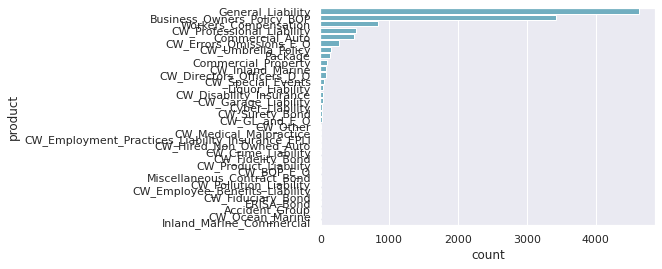

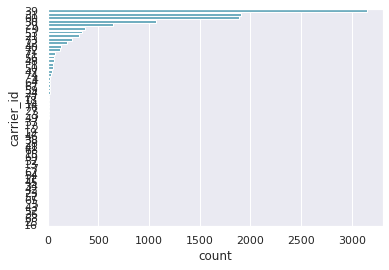

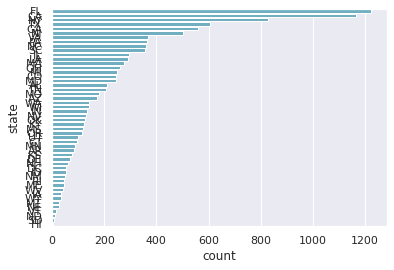

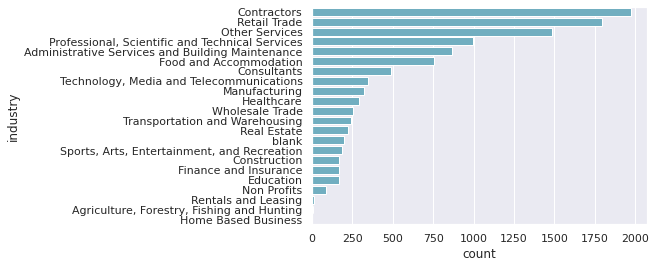

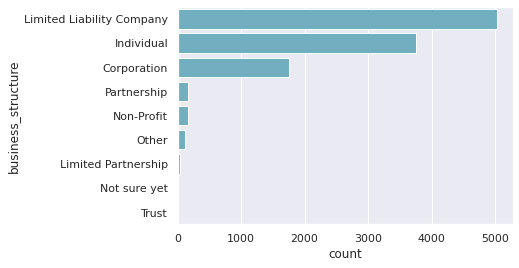

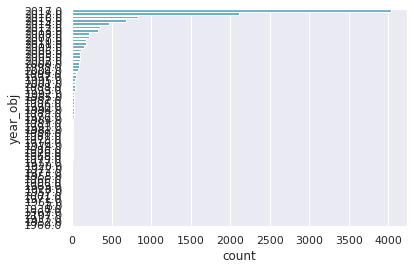

In [35]:
pd.set_option("display.max_rows", None)
for name in name_vars_object:
  print("--------\n")
  print(name, ':\n')
  print(df_quotes_full_train[name].value_counts() / num_rows_quo * 100)
  print("\n")

  plt.figure()
  sns.countplot(y=name, data=df_quotes_full_train, color="c", order = df_quotes_full_train[name].value_counts().index)
  


- State: it appears that all 50 states in the US are represented.
- For Product, Carrier, State and Industry, we are going to group categories with less than 1% of quotes into a category "Others", to avoid residual values.
- Business structure is clearly concentrated around Limited Liability Company, Individual, and Corporation, so the rest can be grouped into one residual set.
- Year is actually transforming into age, but with this analysis we can detect that there are some wrong values like "6" (will be deleted), "1001" (typo for 2001), or "2107" (typo for 2017).


It is important to note that these grouping does not intend to reorder variables regarding the separation of target variable, it is only a way of avoiding many residual values within each column. This is why we are creating only one new group in each case.
Segmentation into major categories (optimal binning) should take into account the target variable "convert", we are not implementing this technique this time.
It is also a matter of trade-off between complexity and number of dummy variables to create.

In [36]:
#Correcting the year
df_quotes_full_train = df_quotes_full_train[~(df_quotes_full_train["year_established"] == 6)]
df_quotes_full_train.loc[df_quotes_full_train["year_established"] == 2107, ["year_established"]] = 2017
df_quotes_full_train.loc[df_quotes_full_train["year_established"] == 1001, ["year_established"]] = 2001

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [37]:
#Grouping residual values
#TODO: do it by filtering count_values on 1%
major_bu_structures = ["Limited Liability Company", "Individual", "Corporation"]
major_products = ["General_Liability", "Business_Owners_Policy_BOP", "Workers_Compensation", "CW_Professional_Liability", "Commercial_Auto", "CW_Errors_Omissions_E_O", "CW_Umbrella_Policy", "Package"]
major_carriers = ["39", "31", "60","30","29","9","53","21","73","22","40","72"]
major_states = ["FL","CA","NY","TX","GA","NJ","VA","PA","NC","SC","IL","LA","MA","OH","MI","CO","MD","AL","TN","MO","AZ","WA","WI","IN","NV","OK","KY","MS","OR"]
major_industries = ["Contractors", "Retail Trade", "Other Services", "Professional, Scientific and Technical Services", "Administrative Services and Building Maintenance", "Food and Accommodation", "Consultants", "Technology, Media and Telecommunications", "Manufacturing", "Healthcare", "Wholesale Trade", "Transportation and Warehousing", "Real Estate", "Sports, Arts, Entertainment, and Recreation", "Construction", "Finance and Insurance", "Education" ]
#blank industry is left out and back into residual group

def grouping_residuals(var_value: str, major_values: list) -> str:
  if var_value in major_values:
    return var_value
  else:
    return "residuals"

df_quotes_full_train['product_res'] = df_quotes_full_train['product'].apply(lambda x: grouping_residuals(x, major_products))
df_quotes_full_train['carrier_id_res'] = df_quotes_full_train['carrier_id'].apply(lambda x: grouping_residuals(x, major_carriers))
df_quotes_full_train['state_res'] = df_quotes_full_train['state'].apply(lambda x: grouping_residuals(x, major_states))
df_quotes_full_train['industry_res'] = df_quotes_full_train['industry'].apply(lambda x: grouping_residuals(x, major_industries))
df_quotes_full_train['business_structure_res'] = df_quotes_full_train['business_structure'].apply(lambda x: grouping_residuals(x, major_bu_structures))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

Let's review current columns and filter the ones we no longer need:

In [38]:
df_quotes_full_train.dtypes

account_uuid               object
product                    object
premium                   float64
carrier_id                 object
convert                     int64
state                      object
industry                   object
year_established          float64
annual_revenue            float64
total_payroll             float64
business_structure         object
num_employees             float64
year_obj                   object
product_res                object
carrier_id_res             object
state_res                  object
industry_res               object
business_structure_res     object
dtype: object

In [39]:
df_quotes_full_train.drop(["product", "carrier_id", "state", "industry", "business_structure", "year_obj"], axis=1, inplace=True)

In [40]:
num_rows_quo, num_cols_quo = df_quotes_full_train.shape
print("The enriched quotes dataset has {0} rows and {1} columns".format(num_rows_quo,num_cols_quo))

The enriched quotes dataset has 11017 rows and 12 columns


In [41]:
df_quotes_full_train.dtypes

account_uuid               object
premium                   float64
convert                     int64
year_established          float64
annual_revenue            float64
total_payroll             float64
num_employees             float64
product_res                object
carrier_id_res             object
state_res                  object
industry_res               object
business_structure_res     object
dtype: object

In [42]:
name_vars_object = [name for name,tipo in df_quotes_full_train.dtypes.iteritems() if 'object' in str(tipo) and name not in name_vars_id]
name_vars_float = [name for name, tipo in df_quotes_full_train.dtypes.iteritems() if 'float' in str(tipo)]
name_vars_int = [name for name, tipo in df_quotes_full_train.dtypes.iteritems() if 'int' in str(tipo)]

#####3.2.1.1 Creation of dummy variables

Before creating dummies, we need to ensure that string values comply with proper nomenclature

In [43]:
def string_to_nomenclature(text):
    return text.strip().replace(',','_').replace('/','_').replace('.','_').replace(' ','_').replace('-','_').replace('(','_').replace(')','_').lower()

In [44]:
df_quotes_full_train[name_vars_object] = df_quotes_full_train[name_vars_object].applymap(lambda x: string_to_nomenclature(x))

#Building dummies in a separate dataset
df_quotes_full_train_dummies = df_quotes_full_train.copy()
df_quotes_full_train_dummies = pd.get_dummies(df_quotes_full_train_dummies,columns=name_vars_object)

This way, having two different datasets, we can try two types of classification algorithms: those who take only numerical variables and those who can take both numerical and categorical variables

#### 3.2.2. Continuous variables

First, we need to build the "age" from the year of establishment

In [45]:
df_quotes_full_train_dummies["company_age"] = pd.datetime.now().year - df_quotes_full_train_dummies["year_established"]
df_quotes_full_train["company_age"] = pd.datetime.now().year - df_quotes_full_train["year_established"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [46]:
df_quotes_full_train_dummies.drop(["year_established"], axis=1, inplace=True)
df_quotes_full_train.drop(["year_established"], axis=1, inplace=True)

#For the analysis of continuous variables we are going to use the dataset without dummies, same conclusions and treatments will apply to the dummies dataset which is exactly a copy
name_vars_object = [name for name,tipo in df_quotes_full_train.dtypes.iteritems() if 'object' in str(tipo) and name not in name_vars_id]
name_vars_float = [name for name, tipo in df_quotes_full_train.dtypes.iteritems() if 'float' in str(tipo)]
name_vars_int = [name for name, tipo in df_quotes_full_train.dtypes.iteritems() if 'int' in str(tipo)]

In [47]:
num_rows_quo, num_cols_quo = df_quotes_full_train_dummies.shape
print("The dummies quotes dataset has {0} rows and {1} columns".format(num_rows_quo,num_cols_quo))

The dummies quotes dataset has 11017 rows and 81 columns


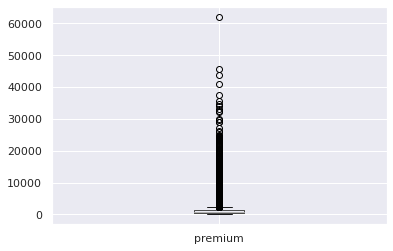

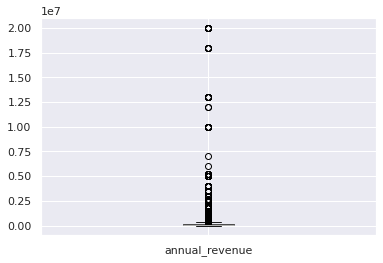

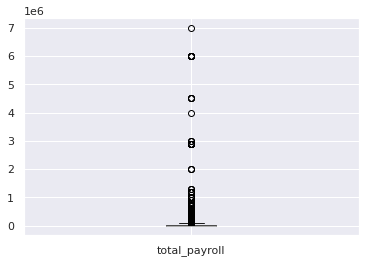

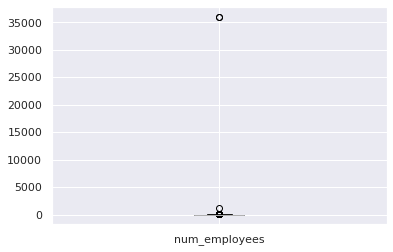

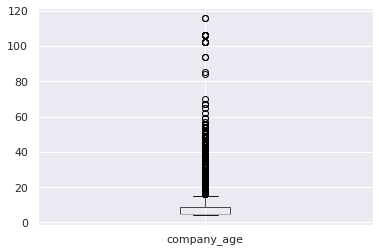

In [48]:
for col in name_vars_float:
  plt.figure()
  df_quotes_full_train.boxplot(column=col)

It can be seen that this variables are very dense at the center, not very disperse, but they present a lot of upper "outliers".
Even though those values could make sense given the nature of the variables, they could be a problem in terms of modeling.
In premium and number of employees, we can get rid of those residual high values above 50000 and 200 respectively, and see what happens then.

In [49]:
df_quotes_full_train = df_quotes_full_train[df_quotes_full_train["num_employees"] < 200]
df_quotes_full_train = df_quotes_full_train[df_quotes_full_train["premium"] < 50000]

df_quotes_full_train_dummies = df_quotes_full_train_dummies[df_quotes_full_train_dummies["num_employees"] < 200]
df_quotes_full_train_dummies = df_quotes_full_train_dummies[df_quotes_full_train_dummies["premium"] < 50000]

In [50]:
num_rows_quo, num_cols_quo = df_quotes_full_train_dummies.shape
print("The dummies quotes dataset has {0} rows and {1} columns".format(num_rows_quo,num_cols_quo))

The dummies quotes dataset has 11013 rows and 81 columns


We have lost barely 4 rows, so it was fair to get rid of those maximum values. Let's take a look at the IQRs:

In [51]:
#Obtain Q1 and Q3
col_iqr_values = []

for col in name_vars_float:
    q1, q3 = df_quotes_full_train[col].quantile([0.25,0.75])
    col_iqr_values.append((col,q1,q3))

In [52]:
n = 4 #we are trying [1.5:0.5:5]
col_limits_values = {}
for name, q1, q3 in col_iqr_values:
    iqr = q3-q1
    lower_lim = q1 - iqr*n
    upper_lim = q3 + iqr*n

    outliers_low = len(df_quotes_full_train[df_quotes_full_train[name] < lower_lim])
    outliers_up = len(df_quotes_full_train[df_quotes_full_train[name] > upper_lim])
    
    col_limits_values[name] = (lower_lim,upper_lim)

    print("In column {0} there are {1} low-outliers and {2} ({3}%) up-outliers".format(name,outliers_low,outliers_up,100*outliers_up/num_rows_quo))

col_limits_values

In column premium there are 0 low-outliers and 659 (5.983837283210751%) up-outliers
In column annual_revenue there are 0 low-outliers and 636 (5.774993189866521%) up-outliers
In column total_payroll there are 0 low-outliers and 555 (5.039498774175974%) up-outliers
In column num_employees there are 0 low-outliers and 627 (5.693271588123127%) up-outliers
In column company_age there are 0 low-outliers and 487 (4.4220466721147735%) up-outliers


{'annual_revenue': (-450000.0, 630000.0),
 'company_age': (-11.0, 25.0),
 'num_employees': (-4.0, 5.0),
 'premium': (-2572.0, 4340.0),
 'total_payroll': (-120000.0, 150000.0)}

Even with an extreme expanding factor of 4 or 5, there are several outliers related to this specific sample. We should not break more the unit of modeling by filtering so many rows, specially without having an expert stakeholder to discuss this issue with.

We definitely would need the opinion of the Data Owner to tell if these are errors or normal values that we can accept.

We are not keeping the rows in this case, in order to avoid a bad training of the model or even risking convergency.

In [53]:
#We do not need to limit the lower bound since it's naturally 0 (see describe cell)
for col in col_limits_values:
  df_quotes_full_train = df_quotes_full_train[df_quotes_full_train[col] <= col_limits_values[col][1]]
  df_quotes_full_train_dummies = df_quotes_full_train_dummies[df_quotes_full_train_dummies[col] <= col_limits_values[col][1]]

In [54]:
num_rows_quo, num_cols_quo = df_quotes_full_train_dummies.shape
print("Both datasets have {0} rows and {1} columns".format(num_rows_quo,num_cols_quo))

Both datasets have 9032 rows and 81 columns


## 4. Understanding the target variable and modeling

So far, we know that we need to train a model to predict "convert" variable. But this is actually only a part of the challenge, since the account value is the actual final goal.

In terms of modeling, we are taking "convert" as the target variable and we will choose a model based on the robustness of the algorithm versus this column, but we will also check RMSE in terms of account value at the end of the analysis.
Hence, we need to keep in mind this "two" target variables.

Also, when making predictions we have to be sure that all rows are available at the end in order to calculate account value. That means that, in case a data treatment applies and some quote rows are discarded (due to lack of information or major errors), we will have to assume that it is not possible to make predictions over the accounts related to those rows.

### 4.1 Conversion rate

The "convert" variable is distributed as follows:

In [55]:
df_quotes_full_train.convert.value_counts() / num_rows_quo * 100

1    60.983171
0    39.016829
Name: convert, dtype: float64

It seems to be almost balanced, so we are not over/undersampling the 1/0s. It is also a good conversion rate.

It can be interesting to observe how the target variable behaves regarding some other variables like: premium, annual revenue, product, carrier or state

In [56]:
df_quotes_full_train["premium_bins"] = pd.qcut(df_quotes_full_train['premium'], q=10, precision=0)

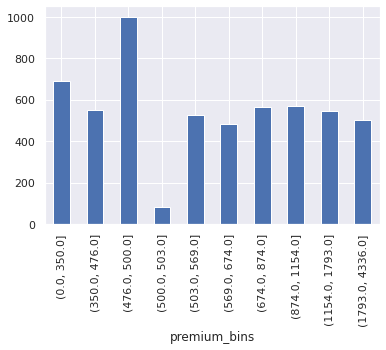

In [57]:
df_quotes_full_train.groupby(["premium_bins"]).convert.sum().plot(kind="bar")

The conversion rate appears to be equally distributed along equally sized bins of premiums, except for the bin aroun 500-530$ where it experiments a decrease.

In [58]:
df_quotes_full_train["annual_revenue_bins"] = pd.qcut(df_quotes_full_train['annual_revenue'], q=9, precision=0)

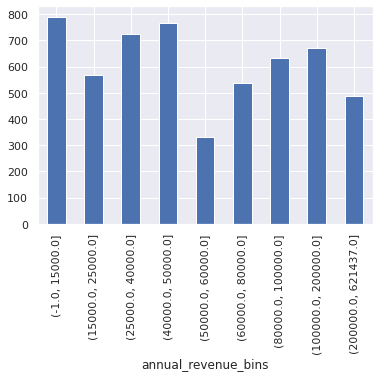

In [59]:
df_quotes_full_train.groupby(["annual_revenue_bins"]).convert.sum().plot(kind="bar")

The conversion does not follow a steady behaviour through equally sized bins of annual revenue.

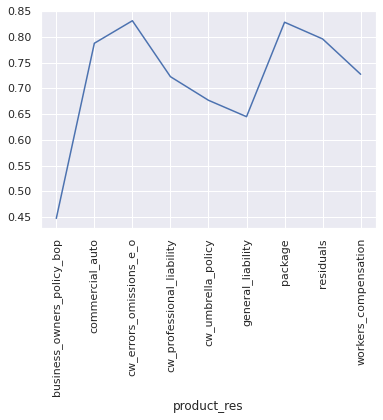

In [60]:
df_quotes_full_train.groupby(["product_res"]).convert.mean().plot(rot=90)

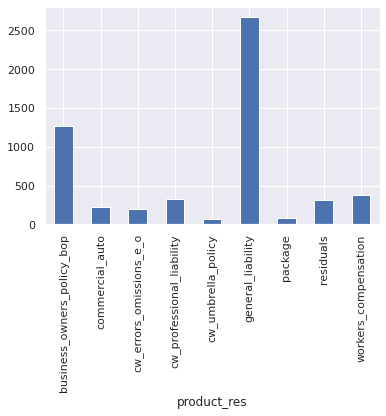

In [61]:
df_quotes_full_train.groupby(["product_res"]).convert.sum().plot(kind="bar")

Commercial Auto, CW Errors Omissions and Package appear to be the products with higher relative conversion rates, taking into account its size.
From a total perspective, business_owners_policy_bop and general_liability are the products that concentrate the higher number of quotes

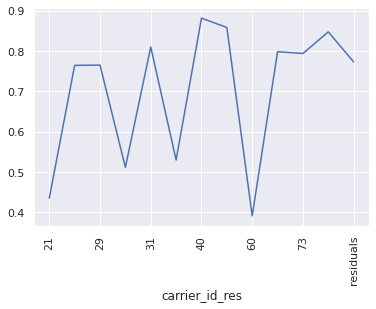

In [62]:
df_quotes_full_train.groupby(["carrier_id_res"]).convert.mean().plot(rot=90)

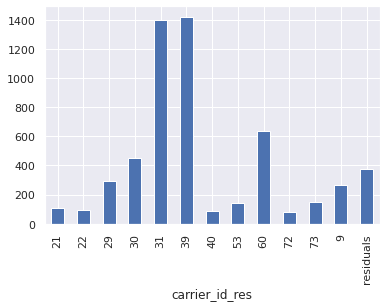

In [63]:
df_quotes_full_train.groupby(["carrier_id_res"]).convert.sum().plot(kind="bar")

Carrier 40 and 53 are the ones with higher conversion rates, taking into account their size in terms of quotes.
From a total perspective, carriers 31 and 39 are the ones that concentrate the higher number of quotes

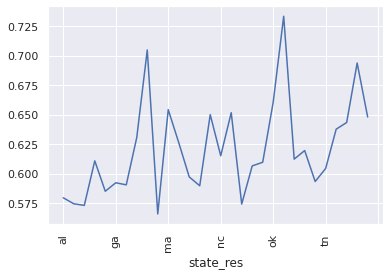

In [64]:
df_quotes_full_train.groupby(["state_res"]).convert.mean().plot(rot=90)

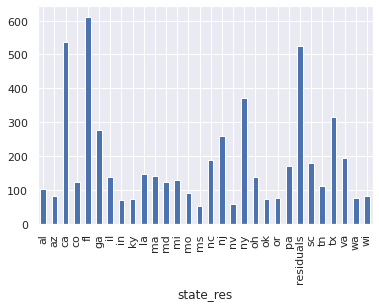

In [65]:
df_quotes_full_train.groupby(["state_res"]).convert.sum().plot(kind="bar")

Conversion rates reach their maximum in Kentucky and Oregan with respect to their size in quotes. From a total perspective, California and Florida are the ones that concentrate the higher number of quotes. All the residual 21 states almost make up to the same amount of quotes than California.

In [66]:
df_quotes_full_train.drop(["premium_bins","annual_revenue_bins"], axis=1,inplace=True)

### 4.2. Correlation analysis

We are using the dummies dataset for this analysis since it contains all variables in numerical format.

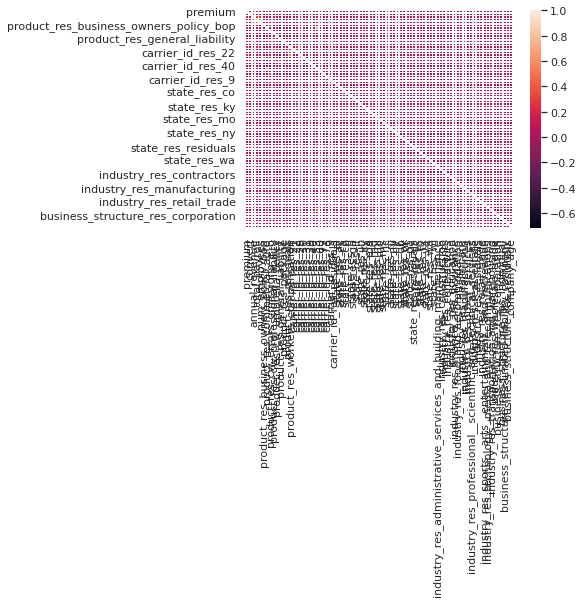

In [67]:
matrix_corr_p = df_quotes_full_train_dummies.drop("account_uuid", axis=1).corr(method='pearson')
sns.heatmap(matrix_corr_p, fmt='.1f',linewidths=0.5,xticklabels=list(matrix_corr_p))

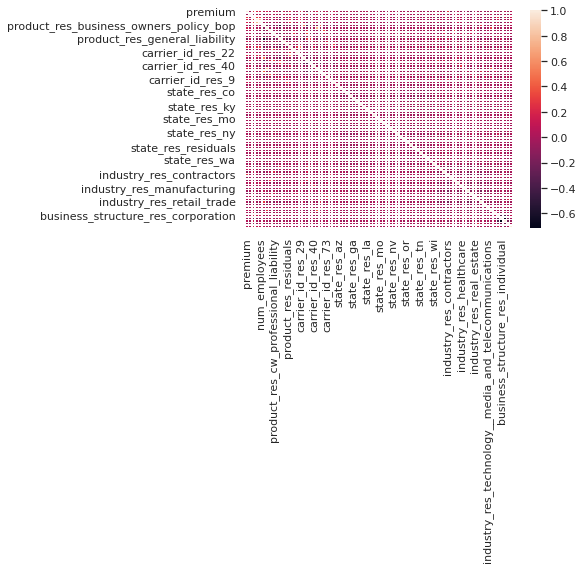

In [68]:
matrix_corr_s = df_quotes_full_train_dummies.drop("account_uuid", axis=1).corr(method='spearman')
sns.heatmap(matrix_corr_s, fmt='.1f',linewidths=0.5)

Let's use Spearman's correlation matrix since it can detect in general monotonous relationships

In [69]:
num_var = len(matrix_corr_s)

corr_value = 0.7
corr_variables = []

for row in range(1,num_var):
    for col in range(0,row):
        if abs(matrix_corr_s.iloc[row,col]) >= corr_value:
            print("Variable {0} is correlated with variable {1} up to {2}".format(list(matrix_corr_s)[row],list(matrix_corr_s)[col],matrix_corr_s.iloc[row,col]))
            corr_variables.append((list(matrix_corr_s)[row],list(matrix_corr_s)[col],matrix_corr_s.iloc[row,col]))
                                  
corr_variables

Variable num_employees is correlated with variable total_payroll up to 0.7606232518686319
Variable carrier_id_res_53 is correlated with variable product_res_commercial_auto up to 0.7109988290101685
Variable business_structure_res_limited_liability_company is correlated with variable business_structure_res_individual up to -0.7145312618676787


[('num_employees', 'total_payroll', 0.7606232518686319),
 ('carrier_id_res_53', 'product_res_commercial_auto', 0.7109988290101685),
 ('business_structure_res_limited_liability_company',
  'business_structure_res_individual',
  -0.7145312618676787)]

It seems natural to find that number of employees and total payroll are highly correlated. On the other hand, we can guess that carrier 53 might be an insurance company specifically dedicated/specialized in Commercial Auto products. First results in Google shows that Forbes says Progressive is the insurance company for this kind of product with highest market share, could it be this one?

In [70]:
print(matrix_corr_s.loc["num_employees","convert"])
print(matrix_corr_s.loc["total_payroll","convert"])

0.01673338907452738
0.010903634117711995


In [71]:
print(matrix_corr_s.loc["carrier_id_res_53","convert"])
print(matrix_corr_s.loc["product_res_commercial_auto","convert"])

0.07025020072499612
0.06596802794456821


In [72]:
print(matrix_corr_s.loc["business_structure_res_limited_liability_company","convert"])
print(matrix_corr_s.loc["business_structure_res_individual","convert"])

-0.012320806584401453
0.004570311561901901


* We can keep number of employees and discard total payroll
* Since the correlationships with the target are almost similar, let's keep product_res_commercial_auto in order not to stick to a specific carrier, and not to lose generality.
* We can keep business_structure_res_limited_liability_company and discard business_structure_res_individual

In [73]:
df_quotes_full_train_dummies.drop("total_payroll", axis=1, inplace=True)
df_quotes_full_train.drop("total_payroll", axis=1, inplace=True)

In [74]:
df_quotes_full_train_dummies.drop("carrier_id_res_53", axis=1, inplace=True)

In [75]:
df_quotes_full_train_dummies.drop("business_structure_res_individual", axis=1, inplace=True)

### 4.3 Modeling

First, the dataset with dummies will be used to model a Logistic Regression and a Random Forest classifiers.
Then we will also try [CatBoost](https://catboost.ai/en/docs/) with the dataset containing plain continuous and categorial variables

In [76]:
random.seed(4)
seed_value = random.randint(1,1234567)

In [77]:
ids_prem = df_quotes_full_train_dummies[["account_uuid","premium"]]

In [78]:
X = df_quotes_full_train_dummies.drop("convert", axis=1)
y = df_quotes_full_train_dummies[["account_uuid","convert"]]

In [79]:
Xcat = df_quotes_full_train.drop("convert", axis=1)
ycat = df_quotes_full_train[["account_uuid","convert"]]

#### 4.3.1 Variables importance and selection

A quick random forest model will allow to assess wich variables can explain better the convert variable, to make an initial selection:

In [80]:
rf = RandomForestClassifier(random_state=seed_value)
rf.fit(X.drop(["account_uuid"], axis=1),y.drop(["account_uuid"], axis=1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(random_state=495029)

In [81]:
ft_importances_df = pd.DataFrame(X.drop(["account_uuid"], axis=1).columns,columns=['features'])
ft_importances_df['importance'] = rf.feature_importances_
ft_importances_df.sort_values('importance',ascending=False,inplace=True)
ft_importances_df['cumulative_sum'] = ft_importances_df['importance'].cumsum()

In [82]:
ft_importances_df['cumulative_sum'] = ft_importances_df['importance'].cumsum()
ft_importances_df

,features,importance,cumulative_sum
0,premium,0.177940,0.177940
1,annual_revenue,0.132543,0.310483
75,company_age,0.085260,0.395744
2,num_employees,0.040796,0.436540
19,carrier_id_res_60,0.029956,0.466496
73,business_structure_res_limited_liability_company,0.028129,0.494625
3,product_res_business_owners_policy_bop,0.026416,0.521040
17,carrier_id_res_39,0.022022,0.543063
16,carrier_id_res_31,0.021241,0.564304
63,industry_res_other_services,0.015728,0.580032


We are going to keep those variables that explain the 95% of the model:

In [83]:
importance_threshold = 0.95
selected_features = list(ft_importances_df[ft_importances_df.cumulative_sum <= importance_threshold].features)

print("{0} candidate variables have been selected\n".format(len(selected_features)))
print(selected_features)

58 candidate variables have been selected

['premium', 'annual_revenue', 'company_age', 'num_employees', 'carrier_id_res_60', 'business_structure_res_limited_liability_company', 'product_res_business_owners_policy_bop', 'carrier_id_res_39', 'carrier_id_res_31', 'industry_res_other_services', 'business_structure_res_corporation', 'state_res_fl', 'industry_res_retail_trade', 'product_res_general_liability', 'state_res_ca', 'industry_res_contractors', 'state_res_residuals', 'industry_res_food_and_accommodation', 'industry_res_professional__scientific_and_technical_services', 'state_res_ny', 'state_res_tx', 'state_res_ga', 'industry_res_administrative_services_and_building_maintenance', 'industry_res_consultants', 'business_structure_res_residuals', 'state_res_va', 'industry_res_manufacturing', 'state_res_nj', 'state_res_nc', 'state_res_il', 'state_res_sc', 'carrier_id_res_residuals', 'carrier_id_res_30', 'carrier_id_res_21', 'carrier_id_res_9', 'state_res_la', 'state_res_pa', 'state_res_m

#### 4.3.2. Variables standardization

It is wise to re-scale the continuous explicative variables, specially for algorithms like Logistic Regression. Since we have a lot of outliers as seen above, the scaler will be RobustScaler

In [84]:
X = df_quotes_full_train_dummies[["account_uuid"] + selected_features]
X.dtypes

account_uuid                                                      object
premium                                                          float64
annual_revenue                                                   float64
company_age                                                      float64
num_employees                                                    float64
carrier_id_res_60                                                  uint8
business_structure_res_limited_liability_company                   uint8
product_res_business_owners_policy_bop                             uint8
carrier_id_res_39                                                  uint8
carrier_id_res_31                                                  uint8
industry_res_other_services                                        uint8
business_structure_res_corporation                                 uint8
state_res_fl                                                       uint8
industry_res_retail_trade                          

In [85]:
features_to_standardize = ["premium","annual_revenue","company_age","num_employees"]

robust_scaler = RobustScaler().fit(X[features_to_standardize])

X["premium_orig"] = X["premium"] #we need to keep it for further calculations
Xcat["premium_orig"] = Xcat["premium"] #we need to keep it for further calculations

X[features_to_standardize] = robust_scaler.transform(X[features_to_standardize])
Xcat[features_to_standardize] = robust_scaler.transform(Xcat[features_to_standardize])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


####4.3.3. Train / Validation split

We need a separate out-of-sample dataset to validate results afterwards, so splitting the training dataset in two is necessary. The conversion rate will be stratified, although random sampling is taking place.

In [86]:
X_train,X_val, y_train,y_val = train_test_split(X,y,train_size = 0.8,stratify = y.convert,random_state=seed_value)
Xcat_train,Xcat_val, ycat_train,ycat_val = train_test_split(Xcat,ycat,train_size = 0.8,stratify = ycat.convert,random_state=seed_value)

In [87]:
print(y_train["convert"].value_counts()*100/len(y_train))
print(y_val["convert"].value_counts()*100/len(y_val))

1    60.982699
0    39.017301
Name: convert, dtype: float64
1    60.985058
0    39.014942
Name: convert, dtype: float64


#### 4.3.4 Models

Since this is a conversion rate prediction problem, it seems that we would want to:
* Refine true positives, in order to optimize further marketing actions resources to increase conversion.
* Avoid as many false negatives as possible, since the opposite would mean losing chances of potential clients.

Therefore, f1-score will be the metric to assess training steps and model selection.

We will also be using GridSearch for parameter tuning, and Cross Validation with 5 and 10 folds to avoid overfitting over a single training set.

In [88]:
metric_score = "f1"

#####4.3.4.1 Logistic Regression

In [89]:
param_grid_lr = {'fit_intercept':[True,False]}

lr_models = {}

t = TicToc()
t.tic()
for solver in ["liblinear", "newton-cg", "sag","saga","lbfgs"]:
  for n_fold in [5,10]:
    logreg = LogisticRegression(random_state=seed_value, max_iter=200, solver=solver)
    grid_logreg = GridSearchCV(logreg,param_grid_lr,scoring=metric_score,cv=n_fold) 
    grid_logreg.fit(X_train.drop(["account_uuid", "premium_orig"], axis=1),y_train.convert)

    lr_models[solver + str(n_fold)] = grid_logreg
t.toc()

Elapsed time is 40.853423 seconds.


In [90]:
for solver in ["liblinear", "newton-cg", "sag","saga","lbfgs"]:
  for n_fold in [5,10]:
    print("Solver {0} & Folds {1}".format(solver,n_fold))
    print("Best LogReg model has parameter: {0}".format(lr_models[solver + str(n_fold)].best_params_))
    print("Best LogReg model has {0} = {1}".format(metric_score,lr_models[solver + str(n_fold)].best_score_))

Solver liblinear & Folds 5
Best LogReg model has parameter: {'fit_intercept': True}
Best LogReg model has f1 = 0.7536629155616567
Solver liblinear & Folds 10
Best LogReg model has parameter: {'fit_intercept': True}
Best LogReg model has f1 = 0.7526719103599451
Solver newton-cg & Folds 5
Best LogReg model has parameter: {'fit_intercept': True}
Best LogReg model has f1 = 0.7539975368031053
Solver newton-cg & Folds 10
Best LogReg model has parameter: {'fit_intercept': True}
Best LogReg model has f1 = 0.7534078845466464
Solver sag & Folds 5
Best LogReg model has parameter: {'fit_intercept': True}
Best LogReg model has f1 = 0.7539975368031053
Solver sag & Folds 10
Best LogReg model has parameter: {'fit_intercept': True}
Best LogReg model has f1 = 0.7534078845466464
Solver saga & Folds 5
Best LogReg model has parameter: {'fit_intercept': True}
Best LogReg model has f1 = 0.7539975368031053
Solver saga & Folds 10
Best LogReg model has parameter: {'fit_intercept': True}
Best LogReg model has f1

Thanks to outliers elimination, all the solvers available in LogisticRegression class from sklearn:

>("newton-cg","liblinear","sag","saga","lbfgs")

presented convergence.


It seems we could keep the LogisticRegression with intercept, 'lbfgs' solver (the standard one) and 5 CV folds.

In [91]:
final_logreg = lr_models['lbfgs' + str(5)]

#####4.3.4.2 Random Forest

In [92]:
param_grid_rf = {'n_estimators':[10,50,100],'max_depth':[2,4,6],'max_features':['auto', None,'log2']}

rf_models = {}

t = TicToc()
t.tic()
for n_fold in [5,10]:
  randfor = RandomForestClassifier(random_state=seed_value)
  grid_rf = GridSearchCV(randfor,param_grid_rf,scoring=metric_score,cv=n_fold)
  grid_rf.fit(X_train.drop(["account_uuid", "premium_orig"], axis=1),y_train.convert)

  rf_models[n_fold] = grid_rf
t.toc()

Elapsed time is 119.404073 seconds.


In [93]:
for n_fold in [5,10]:
  print("Folds {0}".format(n_fold))
  print("Best RandomForest model has parameter: {0}".format(rf_models[n_fold].best_params_))
  print("Best RandomForest model has {0} = {1}".format(metric_score,rf_models[n_fold].best_score_))

Folds 5
Best RandomForest model has parameter: {'max_depth': 6, 'max_features': 'auto', 'n_estimators': 50}
Best RandomForest model has f1 = 0.7642520703329915
Folds 10
Best RandomForest model has parameter: {'max_depth': 4, 'max_features': 'auto', 'n_estimators': 50}
Best RandomForest model has f1 = 0.7631779037934132


It seems we could keep the RandomForest with 5 CV folds, 6-level depth, 50 trees, and sqrt(n_features) considered in each node split.

In [94]:
final_randfor = rf_models[5]

#####4.3.4.3 XGBoost

In [95]:
param_grid_xgb = {'n_estimators':[100, 200],'max_depth':[3,4,6],'max_features':['auto', None,'log2'], 'learning_rate':[0.1,0.05]}

xgb_models = {}

t = TicToc()
t.tic()
for n_fold in [5,10]:
  xgboost = GradientBoostingClassifier(random_state=seed_value)
  grid_xgb = GridSearchCV(xgboost,param_grid_xgb,scoring=metric_score,cv=n_fold)
  grid_xgb.fit(X_train.drop(["account_uuid", "premium_orig"], axis=1),y_train.convert)

  xgb_models[n_fold] = grid_xgb
t.toc()

Elapsed time is 846.628803 seconds.


In [96]:
for n_fold in [5,10]:
  print("Folds {0}".format(n_fold))
  print("Best XGBoost model has parameter: {0}".format(xgb_models[n_fold].best_params_))
  print("Best XGBoost model has {0} = {1}".format(metric_score,xgb_models[n_fold].best_score_))

Folds 5
Best XGBoost model has parameter: {'learning_rate': 0.05, 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 100}
Best XGBoost model has f1 = 0.7666218420153195
Folds 10
Best XGBoost model has parameter: {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 200}
Best XGBoost model has f1 = 0.7655834474435828


It seems we could keep the XGboost with 5 CV folds.

In [97]:
final_xgboost = xgb_models[5]

#####4.3.4.4 CatBoost

For the CatBoost modeling, we are going to use the dataset with no dummies and original categorical variables.
It is necessary to specify column index for those columns that are categorical.

In [98]:
#We need to use an auxiliar copy of the training dataset since column position is specially relevant in this case
Xcat_aux = Xcat_train.drop(["account_uuid", "premium_orig"], axis=1)
name_vars_object = [name for name,tipo in Xcat_aux.dtypes.iteritems() if 'object' in str(tipo)]
index_vars_object = [Xcat_aux.columns.get_loc(col) for col in name_vars_object]

In [99]:
param_grid_cat = {'learning_rate': [0.03, 0.1],'max_depth': [4, 6, 10],'l2_leaf_reg': [1, 3, 5],'iterations': [50, 100, 150]}

cat_models = {}

t = TicToc()
t.tic()
for n_fold in [5,10]:
  catboost = CatBoostClassifier(random_state=seed_value)
  grid_catb = GridSearchCV(catboost,param_grid_cat,scoring=metric_score,cv=n_fold)
  grid_catb.fit(Xcat_aux,ycat_train.convert,cat_features=index_vars_object, verbose=False)

  cat_models[n_fold] = grid_catb
t.toc()

Elapsed time is 571.295200 seconds.


In [100]:
for n_fold in [5,10]:
  print("Folds {0}".format(n_fold))
  print("Best CatBoost model has parameter: {0}".format(cat_models[n_fold].best_params_))
  print("Best CatBoost model has {0} = {1}".format(metric_score,cat_models[n_fold].best_score_))

Folds 5
Best CatBoost model has parameter: {'iterations': 150, 'l2_leaf_reg': 5, 'learning_rate': 0.1, 'max_depth': 10}
Best CatBoost model has f1 = 0.7576084718245522
Folds 10
Best CatBoost model has parameter: {'iterations': 150, 'l2_leaf_reg': 3, 'learning_rate': 0.1, 'max_depth': 10}
Best CatBoost model has f1 = 0.7631452526749529


It seems we could keep the CatBoost model with 10 CV folds. This is an interesting result, since reaching the same f1score as the other algorithms in similar time, it avoids all the dummy variable creation, and also it implies the model has way fewer initial features.
Investing more on fine-tuning might derive in better results, maybe even better than the others (in less time).

In [101]:
final_catboost = cat_models[10]

## 5. Evaluating results

To compare the different algorithms in terms of 1/0s predictions (best models from gridsearch and cross validation loops), the confusion matrix and ROC curve will be looked at.

Please consider that the threshhold over predicted probabilities to calculate 1/0s is set by default at 50%, and in this analysis we will not be performing a threshold optimization.

As said before, we are also using RMSE over predicted account value to select the final model. Both predicted conversion probabilities and predicted conversion 1/0s will be used to calculate expected account value and whichever gives the best RMSE will be selected.

Being strict, if "expected" account value is being demanded, we should use predicted conversion probabilities.

Logistic Regression does not need to be calibrated since it already give unbiased predicted probabilities. However, the other algorithms need calibration in order to be able to use "predict_proba" output as the probability of conversion.

### 5.1. Logistic Regression evaluation

In [102]:
prediction_logreg = final_logreg.predict(X_val.drop(["account_uuid", "premium_orig"], axis=1))
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_val.convert, prediction_logreg)
auc_logreg = auc(fpr_logreg, tpr_logreg)
print("Best iteration of the LogisticRegression model has a predictive power of:\n")
print("AUC: {0}".format(auc_logreg))
print("Gini: {0}".format(2*auc_logreg - 1))
print("Precision score: {0}".format(precision_score(y_val.convert,prediction_logreg)))
print("Recall score: {0}".format(recall_score(y_val.convert,prediction_logreg)))
print("F1 score: {0}".format(f1_score(y_val.convert,prediction_logreg)))


Best iteration of the LogisticRegression model has a predictive power of:

AUC: 0.6854642107837459
Gini: 0.37092842156749173
Precision score: 0.7511071744906997
Recall score: 0.7695099818511797
F1 score: 0.7601972209771403


ROC CURVE for LogReg:



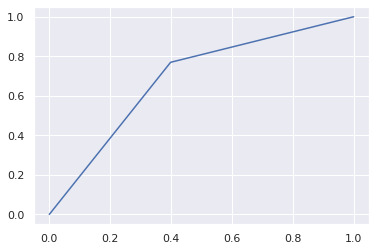

In [103]:
print("ROC CURVE for LogReg:\n")
plt.plot(fpr_logreg,tpr_logreg)

plt.show()

In [104]:
lr_results = X_val[["account_uuid", "premium_orig"]]
lr_results["predict"] = prediction_logreg
lr_results["prob"] = [pair[1] for pair in final_logreg.predict_proba(X_val.drop(["account_uuid", "premium_orig"], axis=1))] #right side of the tuple has the probability of conversion = 1
lr_results["ground_truth"] = y_val.convert

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

### 5.2. Random Forest evaluation

In [105]:
prediction_randfor = final_randfor.predict(X_val.drop(["account_uuid", "premium_orig"], axis=1)) 
fpr_randfor, tpr_randfor, thresholds_randfor = roc_curve(y_val.convert, prediction_randfor)
auc_randfor = auc(fpr_randfor, tpr_randfor)
print("Best iteration of the RandomForest model has a predictive power of:\n")
print("AUC: {0}".format(auc_randfor))
print("Gini: {0}".format(2*auc_randfor - 1))
print("Precision score: {0}".format(precision_score(y_val.convert,prediction_randfor)))
print("Recall score: {0}".format(recall_score(y_val.convert,prediction_randfor)))
print("F1 score: {0}".format(f1_score(y_val.convert,prediction_randfor)))

Best iteration of the RandomForest model has a predictive power of:

AUC: 0.6377257339975029
Gini: 0.27545146799500575
Precision score: 0.6945636623748211
Recall score: 0.8811252268602541
F1 score: 0.7767999999999999


ROC CURVE for RandFor:



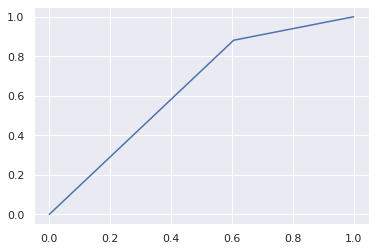

In [106]:
print("ROC CURVE for RandFor:\n")
plt.plot(fpr_randfor,tpr_randfor)
plt.show()

#### 5.2.1. Random Forest calibration

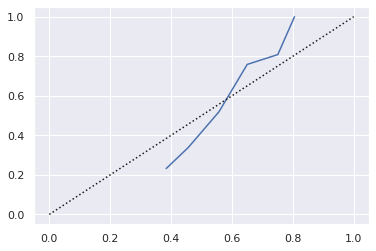

In [107]:
#Reliability curve with biased predicted probabilities
fracpos, meanpred = calibration_curve(y_val.convert, final_randfor.predict_proba(X_val.drop(["account_uuid", "premium_orig"], axis=1))[:, 1], n_bins=10)
plt.plot(meanpred, fracpos)
plt.plot([0, 1], [0, 1], "k:")

In [108]:
#Model calibration to use predict_proba
final_randfor_cal = CalibratedClassifierCV(final_randfor, cv='prefit')
final_randfor_cal.fit(X_train.drop(["account_uuid", "premium_orig"], axis=1), y_train.convert)

CalibratedClassifierCV(base_estimator=GridSearchCV(cv=5,
                                                   estimator=RandomForestClassifier(random_state=495029),
                                                   param_grid={'max_depth': [2,
                                                                             4,
                                                                             6],
                                                               'max_features': ['auto',
                                                                                None,
                                                                                'log2'],
                                                               'n_estimators': [10,
                                                                                50,
                                                                                100]},
                                                   scoring='f1'),
            

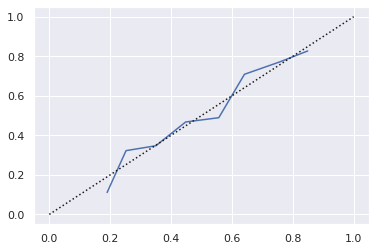

In [109]:
#Reliability curve with unbiased predicted probabilities
fracpos, meanpred = calibration_curve(y_val.convert, final_randfor_cal.predict_proba(X_val.drop(["account_uuid", "premium_orig"], axis=1))[:, 1], n_bins=10)
plt.plot(meanpred, fracpos)
plt.plot([0, 1], [0, 1], "k:")

In [110]:
rf_results = X_val[["account_uuid", "premium_orig"]]
rf_results["predict"] = prediction_randfor
rf_results["prob"] = [pair[1] for pair in final_randfor_cal.predict_proba(X_val.drop(["account_uuid", "premium_orig"], axis=1))] #right side of the tuple has the probability of conversion = 1
rf_results["ground_truth"] = y_val.convert

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

### 5.3. XGBoost evaluation

In [111]:
prediction_xgboost = final_xgboost.predict(X_val.drop(["account_uuid", "premium_orig"], axis=1)) 
fpr_xgboost, tpr_xgboost, thresholds_xgboost = roc_curve(y_val.convert, prediction_xgboost)
auc_xgboost = auc(fpr_xgboost, tpr_xgboost)
print("Best iteration of the XGBoost model has a predictive power of:\n")
print("AUC: {0}".format(auc_xgboost))
print("Gini: {0}".format(2*auc_xgboost - 1))
print("Precision score: {0}".format(precision_score(y_val.convert,prediction_xgboost)))
print("Recall score: {0}".format(recall_score(y_val.convert,prediction_xgboost)))
print("F1 score: {0}".format(f1_score(y_val.convert,prediction_xgboost)))

Best iteration of the XGBoost model has a predictive power of:

AUC: 0.6712971901507253
Gini: 0.3425943803014506
Precision score: 0.7277822257806245
Recall score: 0.8248638838475499
F1 score: 0.7732879625691196


ROC CURVE for XGBoost:



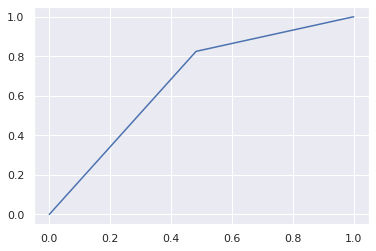

In [112]:
print("ROC CURVE for XGBoost:\n")
plt.plot(fpr_xgboost,tpr_xgboost)
plt.show()

#### 5.3.1. XGBoost calibration

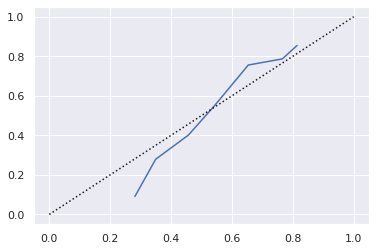

In [113]:
#Reliability curve with biased predicted probabilities
fracpos, meanpred = calibration_curve(y_val.convert, final_xgboost.predict_proba(X_val.drop(["account_uuid", "premium_orig"], axis=1))[:, 1], n_bins=10)
plt.plot(meanpred, fracpos)
plt.plot([0, 1], [0, 1], "k:")

In [114]:
#Model calibration to use predict_proba
final_xgboost_cal = CalibratedClassifierCV(final_xgboost, cv='prefit')
final_xgboost_cal.fit(X_train.drop(["account_uuid", "premium_orig"], axis=1), y_train.convert)

CalibratedClassifierCV(base_estimator=GridSearchCV(cv=5,
                                                   estimator=GradientBoostingClassifier(random_state=495029),
                                                   param_grid={'learning_rate': [0.1,
                                                                                 0.05],
                                                               'max_depth': [3,
                                                                             4,
                                                                             6],
                                                               'max_features': ['auto',
                                                                                None,
                                                                                'log2'],
                                                               'n_estimators': [100,
                                                                      

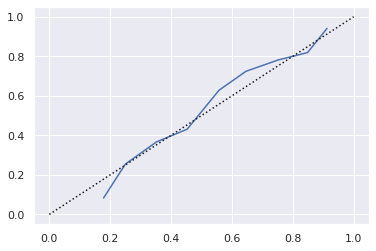

In [115]:
#Reliability curve with unbiased predicted probabilities
fracpos, meanpred = calibration_curve(y_val.convert, final_xgboost_cal.predict_proba(X_val.drop(["account_uuid", "premium_orig"], axis=1))[:, 1], n_bins=10)
plt.plot(meanpred, fracpos)
plt.plot([0, 1], [0, 1], "k:")

In [116]:
xg_results = X_val[["account_uuid", "premium_orig"]]
xg_results["predict"] = prediction_xgboost
xg_results["prob"] = [pair[1] for pair in final_xgboost_cal.predict_proba(X_val.drop(["account_uuid", "premium_orig"], axis=1))] #right side of the tuple has the probability of conversion = 1
xg_results["ground_truth"] = y_val.convert

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

### 5.4. CatBoost evaluation

In [117]:
prediction_catboost = final_catboost.predict(Xcat_val.drop(["account_uuid", "premium_orig"], axis=1)) 
fpr_catboost, tpr_catboost, thresholds_catboost = roc_curve(ycat_val.convert, prediction_catboost)
auc_catboost = auc(fpr_catboost, tpr_catboost)
print("Best iteration of the CatBoost model has a predictive power of:\n")
print("AUC: {0}".format(auc_catboost))
print("Gini: {0}".format(2*auc_catboost - 1))
print("Precision score: {0}".format(precision_score(y_val.convert,prediction_catboost)))
print("Recall score: {0}".format(recall_score(y_val.convert,prediction_catboost)))
print("F1 score: {0}".format(f1_score(y_val.convert,prediction_catboost)))

Best iteration of the CatBoost model has a predictive power of:

AUC: 0.6858870396828463
Gini: 0.3717740793656925
Precision score: 0.7484822202948829
Recall score: 0.7831215970961888
F1 score: 0.765410199556541


ROC CURVE for CatBoost:



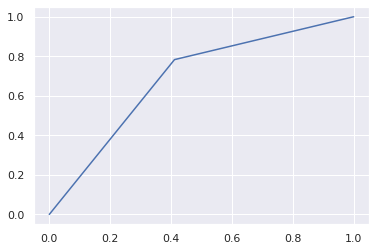

In [118]:
print("ROC CURVE for CatBoost:\n")
plt.plot(fpr_catboost,tpr_catboost)
plt.show()

#### 5.4.1. CatBoost calibration

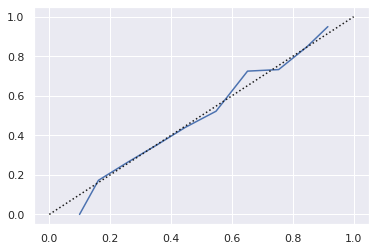

In [119]:
#Reliability curve with biased predicted probabilities
fracpos, meanpred = calibration_curve(ycat_val.convert, final_catboost.predict_proba(Xcat_val.drop(["account_uuid", "premium_orig"], axis=1))[:, 1], n_bins=10)
plt.plot(meanpred, fracpos)
plt.plot([0, 1], [0, 1], "k:")

This reliability curve is already very fitted, so we are not calibrating the catboost model. We can use the initial predicted probabilities.

In [120]:
cb_results = Xcat_val[["account_uuid", "premium_orig"]]
cb_results["predict"] = prediction_catboost
cb_results["prob"] = [pair[1] for pair in final_catboost.predict_proba(Xcat_val.drop(["account_uuid", "premium_orig"], axis=1))] #right side of the tuple has the probability of conversion = 1
cb_results["ground_truth"] = ycat_val.convert

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

### 5.3. RMSE Account value evaluation

Important to note: for the sake of data integrity, in the next analysis we are going to discard those accounts that suffered from filters (except duplicates) over their quotes, as we would not be taking into consideration the whole picture of an account. It would actually not be necessary when calculating RMSE over account values (because the dataset is autocontained), but still, it would not be "the complete picture".

So, we are counting the original quotes per account, and the validation quotes per account, and those accounts for wich this calculation gives different numbers are going down.

In [121]:
original_quotes = pd.DataFrame(df_quotes_train["account_uuid"].value_counts()).reset_index()
val_quotes = pd.DataFrame(lr_results["account_uuid"].value_counts()).reset_index() #it is the same for the other algorithms

In [122]:
val_quotes = val_quotes.merge(original_quotes, how="left", left_on="index", right_on="index", suffixes = [None,"_orig"])
val_quotes_valid = val_quotes[val_quotes["account_uuid"] == val_quotes["account_uuid_orig"]]

In [123]:
def get_valueacc_rmse(ds_results, whole_ids):
  ds_rsme = ds_results.merge(whole_ids["index"],how="inner", left_on="account_uuid", right_on="index").drop("index", axis=1)

  ds_rsme["gt_accvalue"] = ds_rsme["ground_truth"] * ds_rsme["premium_orig"]
  ds_rsme["pred_accvalue"] = ds_rsme["predict"] * ds_rsme["premium_orig"]
  ds_rsme["exp_accvalue"] = ds_rsme["prob"] * ds_rsme["premium_orig"]

  return pd.DataFrame(ds_rsme.groupby("account_uuid").agg({"gt_accvalue": sum, "pred_accvalue":sum, "exp_accvalue": sum})).reset_index()

def print_rmse(results, model):
  print(model)
  print("RMSE over account value 1/0s (predicted): {0}".format(mean_squared_error(results.gt_accvalue, results.pred_accvalue, squared = False)))
  print("RMSE over account value probs (expected): {0}".format(mean_squared_error(results.gt_accvalue, results.exp_accvalue, squared = False)))

In [124]:
rf_rmse = get_valueacc_rmse(rf_results, val_quotes_valid)
lr_rmse = get_valueacc_rmse(lr_results, val_quotes_valid)
xg_rmse = get_valueacc_rmse(xg_results, val_quotes_valid)
cb_rmse = get_valueacc_rmse(cb_results, val_quotes_valid)

In [125]:
print_rmse(lr_rmse, "LOGISTIC REGRESSION")
print_rmse(rf_rmse, "RANDOM FOREST")
print_rmse(xg_rmse, "XGBOOST")
print_rmse(cb_rmse, "CATBOOST")

LOGISTIC REGRESSION
RMSE over account value 1/0s (predicted): 506.62052245316954
RMSE over account value probs (expected): 438.38705343504284
RANDOM FOREST
RMSE over account value 1/0s (predicted): 412.2524038360858
RMSE over account value probs (expected): 396.2508143049642
XGBOOST
RMSE over account value 1/0s (predicted): 435.700632685372
RMSE over account value probs (expected): 408.42913674022094
CATBOOST
RMSE over account value 1/0s (predicted): 466.231278006769
RMSE over account value probs (expected): 420.89587819676126


In order to minimize the RMSE over the test dataset, we will be using the RandomForest model

In [126]:
path = "/content/drive/MyDrive/ColabNotebooks/coverwallet_codetest/assets/"
pickle.dump(final_logreg, open(path + "logregression_pkl", 'wb'))
pickle.dump(final_randfor_cal, open(path + "randomforest_cal_pkl", 'wb'))
pickle.dump(final_xgboost_cal, open(path + "xgboost_cal_pkl", 'wb'))
pickle.dump(final_catboost, open(path + "catboost_pkl", 'wb'))
pickle.dump(robust_scaler, open(path + "robustscaler_pkl", 'wb'))